In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(   #connect to the database
    host="localhost",
    user="root",    
    password="62614",
    database="e_commerce_db")

cur=db.cursor()   #create a cursor object to execute SQL queries

## 1. List all unique cities where customers are located.

In [ ]:
query = """
SELECT DISTINCT
    customer_city
FROM
    customers """

cur.execute(query)
data =cur.fetchall() #fetch all the results of the query
df= pd.DataFrame(data, columns=['customer_city'])  #convert the fetched data into a DataFrame
df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## 2. Count the number of orders placed in 2017.


In [ ]:
query=""" 
select count(order_id) as total_order 
    from orders 
where Date(order_purchase_timestamp) 
    between '2017-01-01' and '2017-12-31' """

cur.execute(query)
data=cur.fetchall() 
"Total order placed in 2017" , data[0][0]

('Total order placed in 2017', 45101)

## 3. Find the total sales per category.

In [5]:
query = """
SELECT 
    Upper(products.product_category), SUM(payments.payment_value)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY products.product_category
ORDER BY SUM(payments.payment_value) DESC
"""
cur.execute(query)
data = cur.fetchall()   
df = pd.DataFrame(data, columns=['product_category', 'total_sales'])
df


,product_category,total_sales
0,BED TABLE BATH,1.712554e+06
1,HEALTH BEAUTY,1.657373e+06
2,COMPUTER ACCESSORIES,1.585330e+06
3,FURNITURE DECORATION,1.430176e+06
4,WATCHES PRESENT,1.429217e+06
...,...,...
69,PC GAMER,2.174430e+03
70,HOUSE COMFORT 2,1.710540e+03
71,CDS MUSIC DVDS,1.199430e+03
72,FASHION CHILDREN'S CLOTHING,7.856700e+02


## 4. Calculate the percentage of orders that were paid in installments.

In [ ]:
query = """
SELECT (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments"""


cur.execute(query)
data = cur.fetchall()
"percentage of orders that were paid in installments is" , data[0][0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

## 5. Count the number of customers from each state. 

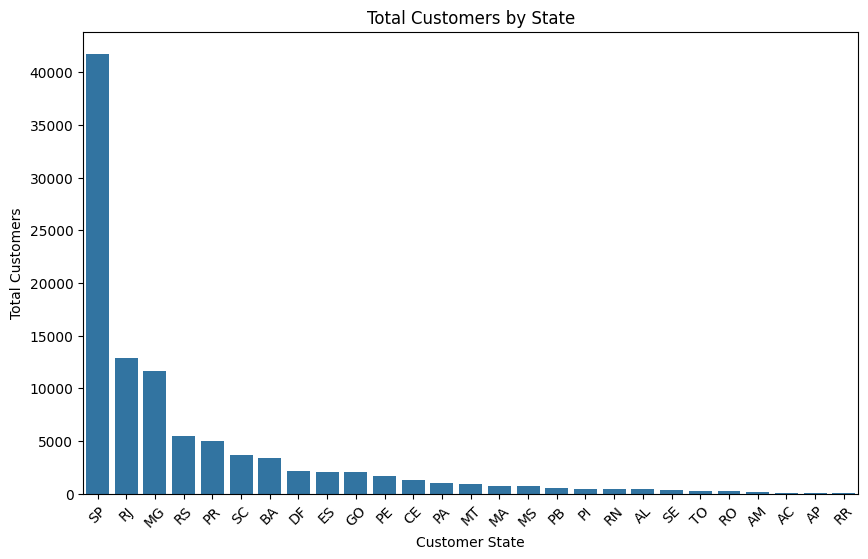

In [13]:
query = """
SELECT customer_state, count(customer_id) as total_customers
        FROM customers
    GROUP BY 
        customer_state
    ORDER BY 
        total_customers DESC  """
        
cur.execute(query)
data = cur.fetchall()   
df = pd.DataFrame(data, columns=['customer_state', 'total_customers'])
df

plt.figure(figsize=(10, 6))
sns.barplot(x='customer_state', y='total_customers', data=df)
plt.title('Total Customers by State')
plt.xlabel('Customer State')           # X-axis is customer_state
plt.ylabel('Total Customers')          # Y-axis is total_customer
plt.xticks(rotation=45)
plt.show()


## 6. Calculate the number of orders per month in 2018.

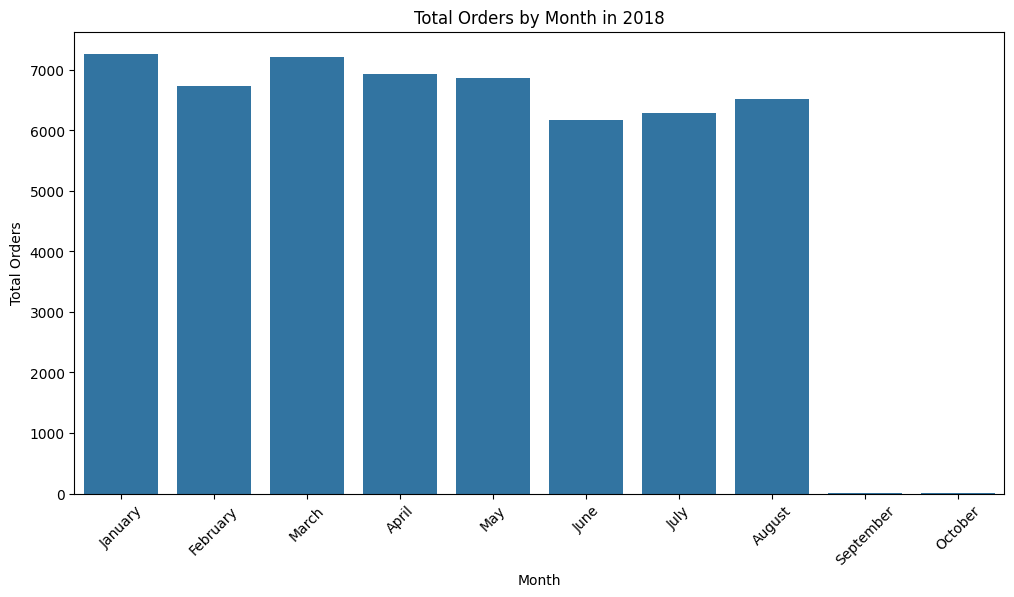

In [15]:
query = """
SELECT 
    MONTH(order_purchase_timestamp) AS month_number,
    MONTHNAME(order_purchase_timestamp) AS month,
    COUNT(order_id) AS total_orders
FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2018
    GROUP BY 
        month_number, month
    ORDER BY 
        month_number
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['month_number', 'month', 'total_orders'])
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_orders', data=df)
plt.title('Total Orders by Month in 2018')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.show()


## 7. Find the average number of products per order, grouped by customer city.

In [16]:
query=""" 
with count_order as
    (
select orders.order_id,orders.customer_id,count(order_items.order_id) as oi 
	FROM orders
	JOIN order_items on order_items.order_id=orders.order_id
group by orders.order_id,orders.customer_id
    )

SELECT 
    customers.customer_city, ROUND(AVG(count_order.oi), 2) as avg_order_items_order
FROM
    customers
        JOIN
    count_order ON customers.customer_id = count_order.customer_id
 group by 
    customers.customer_city
 order by 
    avg_order_Items_order desc
"""
cur.execute(query)  
data = cur.fetchall()
df= pd.DataFrame(data, columns=['customer_city', 'avg_order_items/order'])
df.head(10)

,customer_city,avg_order_items/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


## 8. Calculate the percentage of total revenue contributed by each product category.

In [21]:
query = """
SELECT 
    products.product_category,
    ROUND((SUM(payments.payment_value) / (SELECT 
            SUM(payments.payment_value)
            FROM
            payments)) * 100,2) AS percentage_sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY products.product_category
ORDER BY percentage_sales DESC"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['product_category', 'percentage_sales'])
df.head(10)

    

,product_category,percentage_sales
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [19]:
query = """SELECT 
products.product_category,
round(avg(order_items.price),2) as avg_price,
count(order_items.product_id) as total_items_sold
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['product_category', 'avg_price', 'total_items_sold'])
df.head(10)

arr1 = df['avg_price'].values
arr2 = df['total_items_sold'].values

a=np.corrcoef(arr1, arr2)[0, 1]
print("Correlation between average price and total items sold:", a)

Correlation between average price and total items sold: -0.10631514167157562


## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

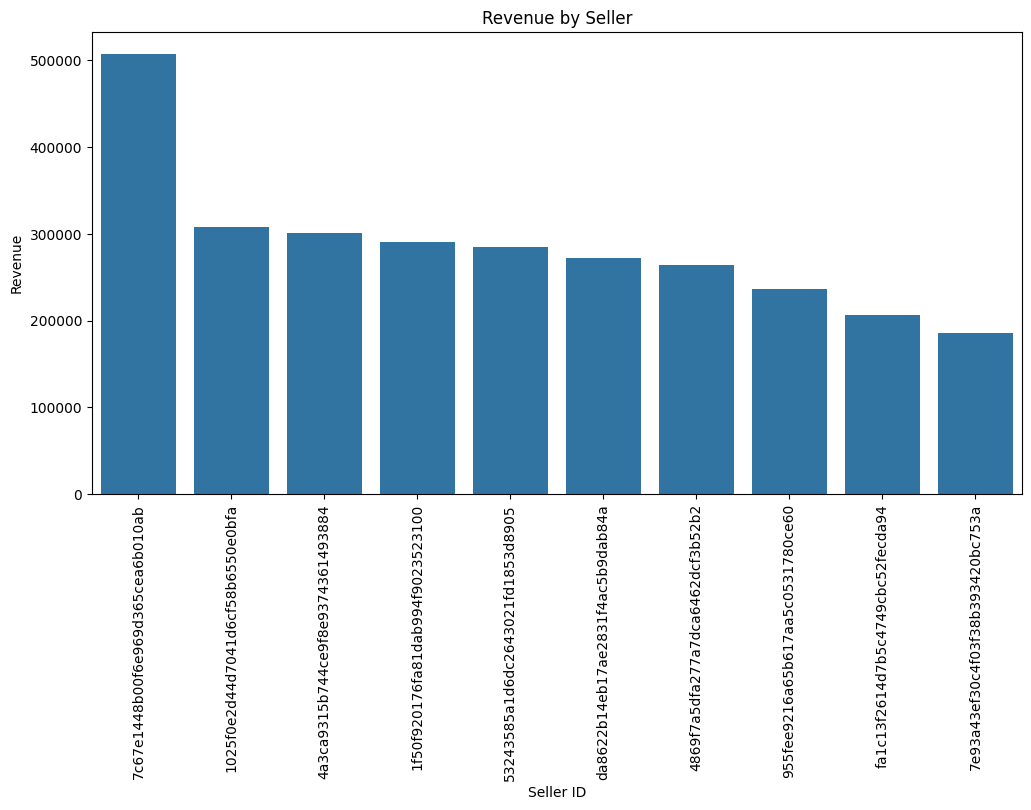

In [ ]:
query = """
SELECT *
FROM (
    SELECT 
        order_items.seller_id,
        SUM(payments.payment_value) AS revenue,
        DENSE_RANK() OVER (ORDER BY SUM(payments.payment_value) DESC) AS rn
    FROM order_items
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
     ) AS seller_revenue
WHERE rn <= 10
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['seller_id', 'revenue', 'rank'])
df.head()
plt.figure(figsize=(12, 6))
sns.barplot(x='seller_id', y='revenue', data=df)
plt.title('Revenue by Seller')
plt.xlabel('Seller ID')
plt.ylabel('Revenue')
plt.xticks(rotation=90)
plt.show()

## 11. Calculate the cumulative sales per month for each year.

In [ ]:
query = """
select 	years,
		months_name,
        payments,
        sum(payments) over(order by years,months) as cumulative_Sales from
        ( 
SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) months,
    MONTHNAME(orders.order_purchase_timestamp) months_name,
    ROUND(SUM(payments.payment_value), 0) AS payments
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY years , months , months_name
ORDER BY years , months , months_name DESC 
		) as a"""
  
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['years', 'months_name', 'payments', 'cumulative_Sales'])
df

,years,months_name,payments,cumulative
0,2016,September,252.0,252.0
1,2016,October,59090.0,59342.0
2,2016,December,20.0,59362.0
3,2017,January,138488.0,197850.0
4,2017,February,291908.0,489758.0
5,2017,March,449864.0,939622.0
6,2017,April,417788.0,1357410.0
7,2017,May,592919.0,1950329.0
8,2017,June,511276.0,2461605.0
9,2017,July,592383.0,3053988.0


## 12. Calculate the year-over-year growth rate of total sales.

In [9]:
query = """
SELECT  
    years,
    ((payments - LAG(payments, 1) OVER (ORDER BY years)) / LAG(payments, 1) OVER (ORDER BY years)) * 100 AS growth_rate
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value),2) AS payments
    FROM orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
) AS a
ORDER BY years;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['years', 'growth_rate'])
df

,years,growth_rate
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## 13. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 1 year of their first purchase.

In [8]:
query = """
WITH first_order AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b as ( SELECT 
    first_order.customer_id,
    COUNT(DISTINCT orders.order_purchase_timestamp) AS total_orders
FROM first_order
JOIN orders 
    ON first_order.customer_id = orders.customer_id
    AND orders.order_purchase_timestamp > first_order.first_order_date
    AND orders.order_purchase_timestamp < DATE_ADD(first_order.first_order_date, INTERVAL 1 YEAR)
GROUP BY first_order.customer_id)

select 100 * (count( distinct first_order.customer_id)/ count(distinct b.customer_id)) 
from first_order left join b 
on first_order.customer_id = b.customer_id ;"""


cur.execute(query)
data = cur.fetchall()
data

[(None,)]

## 14. Identify the top 3 customers who spent the most money in each year.

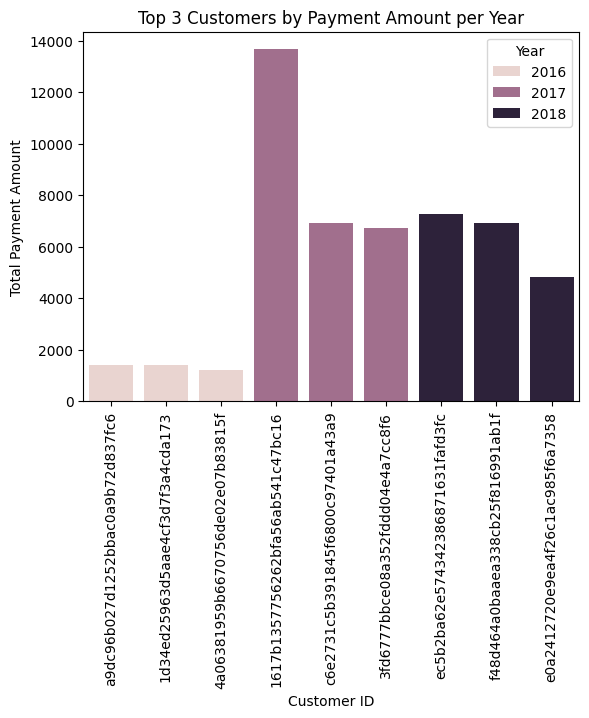

In [ ]:
query = """
select years, customer_id, payment, d_rank
    from
    (
      select year(orders.order_purchase_timestamp) years,
          orders.customer_id,
          sum(payments.payment_value) payment,
          dense_rank() over(partition by year(orders.order_purchase_timestamp)
          order by sum(payments.payment_value) desc) d_rank
      from orders join payments 
          on payments.order_id = orders.order_id
          group by year(orders.order_purchase_timestamp),
      orders.customer_id
    ) as a
where d_rank <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years") #c
plt.title('Top 3 Customers by Payment Amount per Year')
plt.xlabel('Customer ID')
plt.ylabel('Total Payment Amount')
plt.legend(title='Year')
plt.xticks(rotation = 90)
plt.show()